In [2]:
import numpy as np
from module import *

In [2]:

# Example usage
n = 500  # Total nodes
k = 10   # Controlled nodes
agent_nodes = np.array([i for i in range(k)])  # First k nodes controlled
agent_values = np.random.choice([-1, 0, 1], size=k)  # Fixed values chosen beforehand

obj_nodes = np.array([i for i in range(n // 2, n // 2 + 1)])  # Example selection
proxy_nodes = np.array([i for i in range(n // 2 + 1, n // 2 + 2)])

esn = EchoStateNetwork(n, spectral_radius=1.1, alpha=0.1)
states = esn.run(steps=500, discard=100, agent_nodes=agent_nodes, agent_values=agent_values)
avg_obj, avg_proxy = compute_averages(states, obj_nodes, proxy_nodes)

print("Objective node averages:", avg_obj)
print("Proxy node averages:", avg_proxy)

Objective node averages: 0.009145817909099489
Proxy node averages: 0.0004876212691049972


In [61]:
states = esn.run(steps=500, discard=100, agent_nodes=agent_nodes, agent_values=agent_values)
avg_obj, avg_proxy = compute_averages(states, obj_nodes, proxy_nodes)

print("Objective node averages:", avg_obj)
print("Proxy node averages:", avg_proxy)

Objective node averages: -0.03260327049666292
Proxy node averages: -0.055584452376558374


In [13]:
import numpy as np

from scipy.optimize import minimize, brute

n = 100  # Total nodes
k = 10   # Controlled nodes
agent_nodes = np.array([i for i in range(k)])  # First k nodes controlled
agent_initial_values = np.random.choice([-1, 0, 1], size=k)  # Fixed values chosen beforehand

obj_nodes = np.array([i for i in range(n // 2, n // 2 + 5)])  # Example selection
proxy_nodes = np.array([i for i in range(n // 2 + 5, n // 2 + 10)])



def to_optimize(InActions):
    agent_values = InActions
    states = esn.run(steps=500, discard=100, agent_nodes=agent_nodes, agent_values=agent_values)
    avg_obj, avg_proxy = compute_averages(states, obj_nodes, proxy_nodes)
    return -1* avg_proxy

res = minimize(to_optimize,  agent_initial_values, method="powell")

states = esn.run(steps=500, discard=0, agent_nodes=agent_nodes, agent_values=res.x)
avg_obj, avg_proxy = compute_averages(states, obj_nodes, proxy_nodes)

print("Objective node averages:", avg_obj)
print("Proxy node averages:", avg_proxy)

Objective node averages: -0.16953650723682423
Proxy node averages: -0.012642921495415908


In [5]:
#
#def to_optimize(*params):#InActions):
#    print("params", params)
#    agent_values = params
#    states = esn.run(steps=500, discard=100, agent_nodes=agent_nodes, agent_values=agent_values)
#    avg_obj, avg_proxy = compute_averages(states, obj_nodes, proxy_nodes)
#    return -1* avg_proxy

#ranges = (slice(-1, 2, 1),) * k
#res = brute(to_optimize, ranges)

In [6]:
import matplotlib.pyplot as plt

def nodeProxy0to100(repeats):
    num_outnode = 10
    plt.subplots(figsize=(12, 4))
    P_List = [[] for k in range(num_outnode+1)]
    O_List = [[] for k in range(num_outnode+1)]

    for iteration in range(repeats):
        if iteration//50 == iteration/50:
            print(iteration)
        n = 500  # Total nodes
        k = 10   # Controlled nodes
        agent_nodes = np.array([i for i in range(k)])  # First k nodes controlled
        agent_initial_values = np.random.choice([-1, 0, 1], size=k)  # Fixed values chosen beforehand

        obj_nodes = np.array([i for i in range(n // 2, n // 2 + num_outnode)])  # Example selection
        

        esn = EchoStateNetwork(n,spectral_radius= 0.9)

        def to_optimize(InActions,proxy_nodes):
            agent_values = InActions
            states = esn.run(steps=500, discard=100, agent_nodes=agent_nodes, agent_values=agent_values)
            avg_obj, avg_proxy = compute_averages(states, obj_nodes, proxy_nodes)
            return -1* avg_proxy #minimize will optimize the value
        


        for nodes_out in range(1,num_outnode+1, num_outnode//5):
            proxy_nodes = np.array([i for i in range(n // 2 + nodes_out, n // 2 + num_outnode + nodes_out)])
            res = minimize(to_optimize, agent_initial_values, args=(proxy_nodes), method="powell")

            states = esn.run(steps=500, discard=100, agent_nodes=agent_nodes, agent_values=res.x)
            avg_obj, avg_proxy = compute_averages(states, obj_nodes, proxy_nodes)
            P_List[nodes_out].append(avg_proxy)
            O_List[nodes_out].append(avg_obj)
    p = []
    for nodes_out in range(1,num_outnode+1, num_outnode//5):   
        percent  =(num_outnode-nodes_out)/num_outnode
        p+= (plt.plot( percent, np.mean(P_List[nodes_out]), '*', label = 'proxy_' + '{:.1%}'.format(percent)  ))
       
    for nodes_out in range(1,num_outnode+1, num_outnode//5):   
        percent  =(num_outnode-nodes_out)/num_outnode
        plt.plot(percent, np.mean(O_List[nodes_out]),'*', label = 'goal_' + '{:.1%}'.format(percent), color = p[0].get_color(), alpha = 0.5  )
        plt.plot(percent, percent * np.mean(P_List[nodes_out]),'*', label = 'percent' + '{:.1%}'.format(percent), color = 'k', alpha = 0.5  )
        p = p[1:]
    #plt.ylim((-1,1))
    plt.grid(True)
    plt.legend(ncol=2)
    plt.show()



0


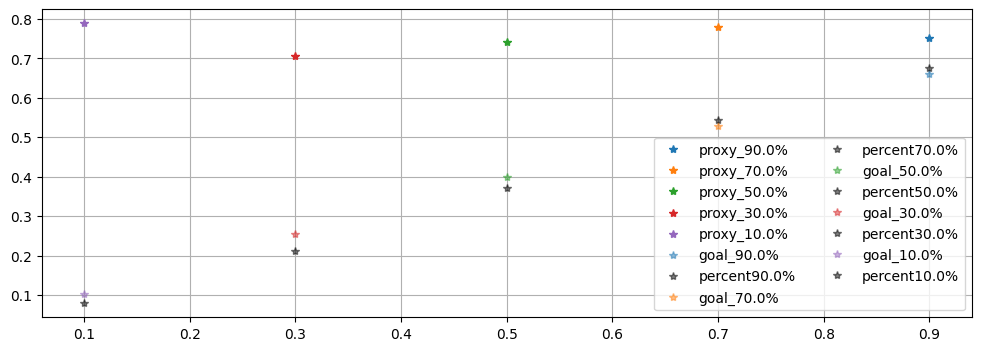

In [ ]:
#nodeProxy0to100(10)

## Now looking at temporal solutions 


In [7]:
def compute_temp_averages(states, obj_nodes, proxy_prop):
    """
    Compute time-averaged values for objective and proxy nodes.

    Parameters
    ----------
    states : np.ndarray
        Array of reservoir states over time.
    obj_nodes : array-like
        Indices of objective nodes.
    proxy_prop : float
        Proportion of the simulation that serves as proxy

    Returns
    -------
    tuple
        Averages of objective and proxy nodes.
    """
    avg_obj = np.mean(states[:, obj_nodes])
    length  =  np.size(states,0)
    avg_proxy = np.mean(states[:max(1, int(proxy_prop * length)) , obj_nodes])
    return avg_obj, avg_proxy

[0 1 2 3 4 5 6 7 8 9] [ 0.          0.          0.85467572  0.9         0.9        -0.9
  0.          0.          0.9        -0.9       ] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 1 2 3 4 5 6 7 8 9] [ 0.          0.          0.72785228  0.81        0.81       -0.81
  0.          0.          0.81       -0.81      ] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 1 2 3 4 5 6 7 8 9] [ 0.          0.          0.61742292  0.729       0.729      -0.72886196
  0.          0.          0.729      -0.729     ] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 1 2 3 4 5 6 7 8 9] [ 0.00000000e+00  2.67581714e-06  5.21484116e-01  6.56100000e-01
  6.56100000e-01 -6.55602565e-01  0.00000000e+00  0.00000000e+00
  6.56100000e-01 -6.56100000e-01] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 1 2 3 4 5 6 7 8 9] [-2.00953625e-09  1.20462795e-05  4.38323414e-01  5.90490000e-01
  5.90489272e-01 -5.89369987e-01  0.00000000e+00  0.00000000e+00
  5.90490000e-01 -5.90490000e-01] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 1 2 3 4 5 6 7 8 9] [-1.98112752e-08  3.2450

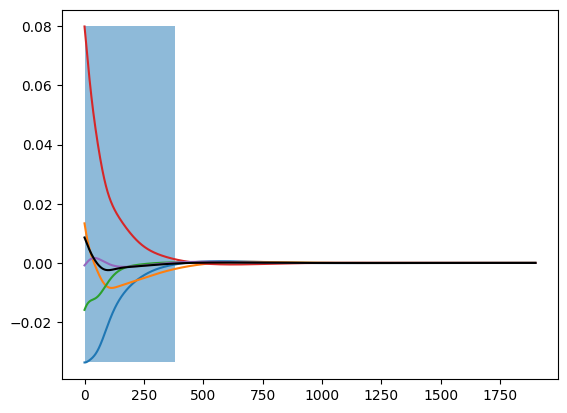

In [9]:
n = 500  # Total nodes
k = 10   # Controlled nodes
agent_nodes = np.array([i for i in range(k)])  # First k nodes controlled
agent_initial_values = np.random.choice([-1, 0, 1], size=k)  # Fixed values chosen beforehand

obj_nodes = np.array([i for i in range(n // 2, n // 2 + 5)])  # Example selection
proxy_prop = 0.2



def to_optimize_temp(InActions, proxy_prop):
    agent_values = InActions.astype(int)
    states = esn.run(steps=500, discard=100, agent_nodes=agent_nodes, agent_values=agent_values)
    avg_obj, avg_proxy = compute_temp_averages(states, obj_nodes, proxy_prop)
    return -1* avg_proxy

esn = EchoStateNetwork(n, spectral_radius=1, alpha = 0.1)
#res = minimize(to_optimize_temp, agent_initial_values, args = ( proxy_prop), method="powell")

states = esn.run(steps=2000, discard=100, agent_nodes=agent_nodes, agent_values=agent_initial_values) #res.x)
print(proxy_prop *np.size(states,0))
avg_obj, avg_proxy = compute_temp_averages(states, obj_nodes, proxy_prop)

print("Objective node averages:", avg_obj)
print("Proxy node averages:", avg_proxy)
plt.plot(states[:,50:55] )
s = np.array([k for k in range(len(states[:,0]))])
mini = np.min(states[:,50:55])
maxi = np.max(states[:,50:55])
plt.fill_between(range(len(s)), mini, maxi, where=(s < proxy_prop* max(s)) , alpha=0.5)
plt.plot(np.mean(states[:,50:55], axis = 1), color = 'k' )

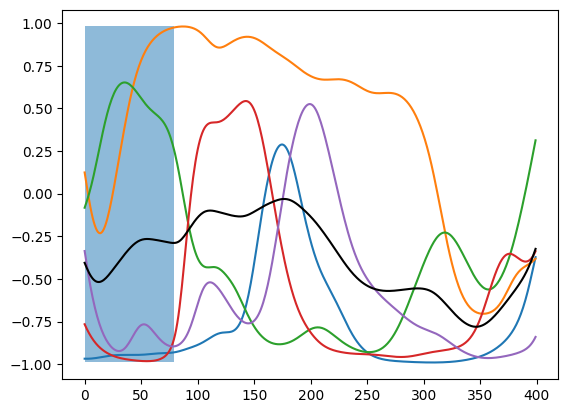

Exception ignored in: <function TransformNode.set_children.<locals>.<lambda> at 0x000002000323EB60>
Traceback (most recent call last):
  File "C:\Users\paulb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\transforms.py", line 198, in <lambda>
    self, lambda _, pop=child._parents.pop, k=id_self: pop(k))
                                                       ^^^^^^
KeyboardInterrupt: 


80.0
Objective node averages: 0.007535867203193384
Proxy node averages: 0.11844615817037278


<Figure size 640x480 with 0 Axes>

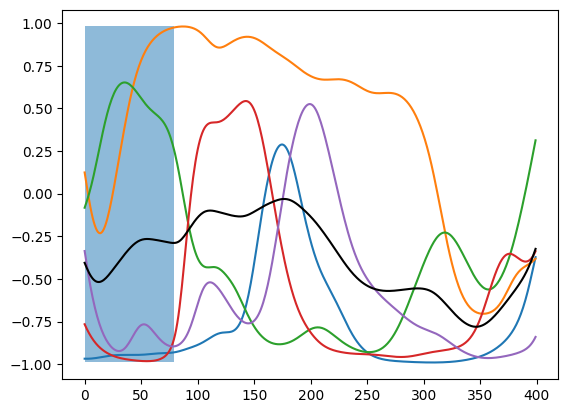

In [17]:
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
from IPython import display

plt.clf()

np.random.seed(0)
fig, ax = plt.subplots(1, 1)
hdisplay = display.display("", display_id=True)
agent_initial_values = np.random.choice([-1, 0, 1], size=k)
np.random.seed(2)
def to_optimize_temp_plot(InActions):
    agent_values = InActions.astype(int)#
    states = esn.run(steps=500, discard=100, agent_nodes=agent_nodes, agent_values=agent_values)
    avg_obj, avg_proxy = compute_temp_averages(states, obj_nodes, proxy_prop)
    ax.cla()
    ax.plot(states[:,50:55] )
    s = np.array([k for k in range(len(states[:,0]))])
    mini = np.min(states[:,50:55])
    maxi = np.max(states[:,50:55])
    ax.plot(np.mean(states[:,50:55], axis = 1), color = 'k' )
    ax.fill_between(range(len(s)), mini, maxi, where=(s < proxy_prop* max(s)) , alpha=0.5)
    hdisplay.update(fig)
    #time.sleep(3)
    avg_obj, avg_proxy = compute_temp_averages(states, obj_nodes, proxy_prop)
    return -1* avg_proxy

esn = EchoStateNetwork(500, spectral_radius=2, alpha = 0.1)
res = minimize(to_optimize_temp_plot, agent_initial_values, method="powell")
states = esn.run(steps=500, discard=100, agent_nodes=agent_nodes, agent_values=res.x)
print(proxy_prop *np.size(states,0))
avg_obj, avg_proxy = compute_temp_averages(states, obj_nodes, proxy_prop)

print("Objective node averages:",-1* avg_obj)
print("Proxy node averages:",-1* avg_proxy)






In [60]:
def nodeProxy0to100(repeats):
    num_outnode = 10
    plt.subplots(figsize=(12, 4))
    P_List = [[] for k in range(num_outnode+1)]
    O_List = [[] for k in range(num_outnode+1)]

    for iteration in range(repeats):
        if iteration//50 == iteration/50:
            print(iteration)
        n = 100  # Total nodes
        k = 100   # Controlled nodes
        agent_nodes = np.array([i for i in range(k)])  # First k nodes controlled
        agent_initial_values = np.random.choice([-1, 0, 1], size=k)  # Fixed values chosen beforehand

        obj_nodes = np.array([i for i in range(n // 2, n // 2 + num_outnode)])  # Example selection
        

        esn = EchoStateNetwork(500,spectral_radius= 2, alpha = 0.1)

        def to_optimize_temp(InActions, proxy_prop):
            agent_values = InActions.astype(int)
            states = esn.run(steps=500, discard=100, agent_nodes=agent_nodes, agent_values=agent_values)
            avg_obj, avg_proxy = compute_temp_averages(states, obj_nodes, proxy_prop)
            return -1* avg_proxy
                


        for nodes_out in range(1,num_outnode+1, num_outnode//5):
            proxy_prop = nodes_out/num_outnode
            res = minimize(to_optimize_temp, agent_initial_values, args = (proxy_prop))

            states = esn.run(steps=1000, discard=100, agent_nodes=agent_nodes, agent_values=res.x)
            avg_obj, avg_proxy = compute_temp_averages(states, obj_nodes, proxy_prop)
            P_List[nodes_out].append(avg_proxy)
            O_List[nodes_out].append(avg_obj)
    p = []
    for nodes_out in range(1,num_outnode+1, num_outnode//5):   
        percent  =(num_outnode-nodes_out)/num_outnode
        p+= (plt.plot( percent, np.mean(P_List[nodes_out]), '*', label = 'proxy_' + '{:.1%}'.format(percent)  ))
       
    for nodes_out in range(1,num_outnode+1, num_outnode//5):   
        percent  =(num_outnode-nodes_out)/num_outnode
        print(p)
        plt.plot(percent, np.mean(O_List[nodes_out]),'*', label = 'goal_' + '{:.1%}'.format(percent), color = p[0].get_color(), alpha = 0.5  )
        plt.plot(percent, percent * np.mean(P_List[nodes_out]),'*', label = 'percent' + '{:.1%}'.format(percent), color = 'k', alpha = 0.5  )
        p = p[1:]
    #plt.ylim((-1,1))
    plt.grid(True)
    plt.legend(ncol=2)
    plt.show()


0
[<matplotlib.lines.Line2D object at 0x000001FA74B377D0>, <matplotlib.lines.Line2D object at 0x000001FA7496DB10>, <matplotlib.lines.Line2D object at 0x000001FA7496E510>, <matplotlib.lines.Line2D object at 0x000001FA74BACD10>, <matplotlib.lines.Line2D object at 0x000001FA6EA12350>]
[<matplotlib.lines.Line2D object at 0x000001FA7496DB10>, <matplotlib.lines.Line2D object at 0x000001FA7496E510>, <matplotlib.lines.Line2D object at 0x000001FA74BACD10>, <matplotlib.lines.Line2D object at 0x000001FA6EA12350>]
[<matplotlib.lines.Line2D object at 0x000001FA7496E510>, <matplotlib.lines.Line2D object at 0x000001FA74BACD10>, <matplotlib.lines.Line2D object at 0x000001FA6EA12350>]
[<matplotlib.lines.Line2D object at 0x000001FA74BACD10>, <matplotlib.lines.Line2D object at 0x000001FA6EA12350>]


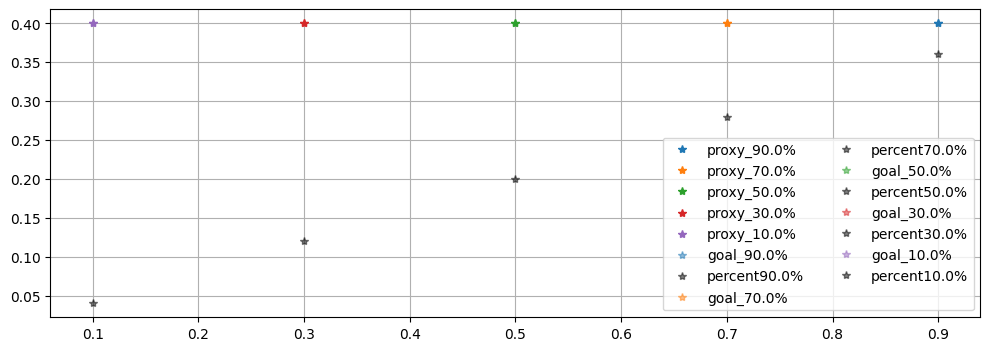

In [61]:
nodeProxy0to100(1)

## Now trying with a genetic algorithm package 


C:\Users\paulb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geneticalgorithm2\geneticalgorithm2.py:197: UserWarning: function is deprecated in init constructor and will be removed in version 7. Move this argument to run() method
  warnings.warn(



Set: Average time of function evaluating (secs): 0.002382485866546631 (total = 0.23824858665466309)

Best score before optimization: -0.27488094091921345
                                                                                                                                                                                                        
 The best found solution:
 [ 0.  1. -1. -1. -1. -1. -1.  1. -1. -1.]

 Objective function:
 -0.4048072073891701

 Used generations: 200
 Used time: 34.5 seconds


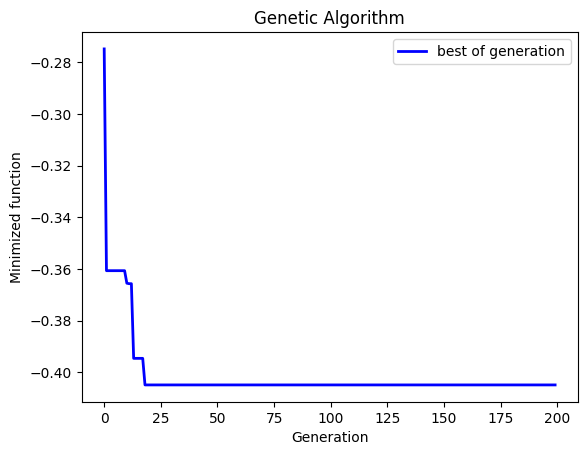

[np.float64(-0.27488094091921345), np.float64(-0.3606321869335757), np.float64(-0.3606321869335757), np.float64(-0.3606321869335757), np.float64(-0.3606321869335757), np.float64(-0.3606321869335757), np.float64(-0.3606321869335757), np.float64(-0.3606321869335757), np.float64(-0.3606321869335757), np.float64(-0.3606321869337596), np.float64(-0.3654811806515818), np.float64(-0.36565886093503136), np.float64(-0.36565886093503136), np.float64(-0.3945333259537447), np.float64(-0.394533325954678), np.float64(-0.394533325954678), np.float64(-0.394533325954678), np.float64(-0.39453332595495544), np.float64(-0.4048072073890755), np.float64(-0.4048072073890755), np.float64(-0.4048072073890755), np.float64(-0.40480720738912795), np.float64(-0.40480720738912795), np.float64(-0.40480720738912795), np.float64(-0.40480720738912795), np.float64(-0.40480720738912795), np.float64(-0.40480720738912795), np.float64(-0.40480720738916487), np.float64(-0.40480720738916487), np.float64(-0.40480720738916487),

In [10]:
from geneticalgorithm2 import GeneticAlgorithm2 as ga





# Example usage
n = 100  # Total nodes
k = 10   # Controlled nodes
agent_nodes = np.array([i for i in range(k)])  # First k nodes controlled
agent_values = np.random.choice([-1, 0, 1], size=k)  # Fixed values chosen beforehand

varbound=np.array([[-1,1]]*k)
obj_nodes = np.array([i for i in range(n // 2, n // 2 + 5)])  # Example selection
proxy_prop = 0.2

esn = EchoStateNetwork(n)


model=ga(function=to_optimize_temp,dimension=k,variable_type='int',variable_boundaries=varbound)

model.run()

convergence=model.report
solution=model.result

print(convergence)
print("here is the solution" ,solution.variable)
states = esn.run(steps=500, discard=100, agent_nodes=solution.variable.astype(int), agent_values=res.x)
print(proxy_prop *np.size(states,0))
avg_obj, avg_proxy = compute_temp_averages(states, obj_nodes, proxy_prop)

print("Objective node averages:", avg_obj)
print("Proxy node averages:", avg_proxy)



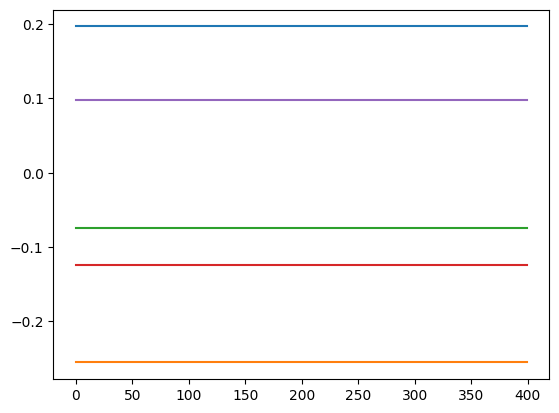

In [11]:
plt.plot(states[:,25:30])

In [4]:
import numpy as np

num = np.tanh(np.array([1,2,3]))


print(f"{num:.2f}")

TypeError: unsupported format string passed to numpy.ndarray.__format__